# Basic Mesh Composition and Plotting

We are about to build a compound mesh by transforming parts of a voxlized cylinder into tetrahedra and lines. Then we do some plotting and review the basics of configuring plots.

The following block shows a basic example with minimal API usage and common `NumPy` operations:

In [26]:
from polymesh.space import CartesianFrame
from polymesh.recipes import cylinder
from polymesh import PolyData, LineData, PointData
from polymesh.cells import H8, Q4, L2
from polymesh.topo.tr import H8_to_L2, H8_to_Q4
from polymesh.topo import detach_mesh_bulk
from neumann.array import minmax
import numpy as np

min_radius = 5
max_radius = 25
h = 50
angle = 1

shape = (min_radius, max_radius), angle, h
frame = CartesianFrame(dim=3)
cyl = cylinder(shape, size=5., voxelize=True, frame=frame)

coords = cyl.coords()
topo = cyl.topology()
centers = cyl.centers()

cxmin, cxmax = minmax(centers[:, 0])
czmin, czmax = minmax(centers[:, 2])
cxavg = (cxmin + cxmax)/2
czavg = (czmin + czmax)/2
b_upper = centers[:, 2] > czavg
b_lower = centers[:, 2] <= czavg
b_left = centers[:, 0] < cxavg
b_right = centers[:, 0] >= cxavg
iL2 = np.where(b_upper & b_right)[0]
iTET4 = np.where(b_upper & b_left)[0]
iH8 = np.where(b_lower)[0]
_, tL2 = H8_to_L2(coords, topo[iL2])
_, tQ4 = H8_to_Q4(coords, topo[iTET4])
tH8 = topo[iH8]

pd = PointData(coords=coords, frame=frame)
mesh = PolyData(pd, frame=frame)
cdL2 = L2(topo=tL2, frames=frame)
mesh['lines', 'L2'] = LineData(cdL2, frame=frame)

cdQ4 = Q4(topo=tQ4, frames=frame)
mesh['surfaces', 'Q4'] = PolyData(cdQ4, frame=frame)

cH8, tH8 = detach_mesh_bulk(coords, tH8)
pdH8 = PointData(coords=cH8, frame=frame)
cdH8 = H8(topo=tH8, frames=frame)
mesh['bodies', 'H8'] = PolyData(pdH8, cdH8, frame=frame)


In [27]:
mesh['surfaces', 'Q4'].plot(notebook=True, jupyter_backend='pythreejs',
                            show_edges=True, window_size=(600, 480))


Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [28]:
mesh['bodies', 'H8'].surface().plot(notebook=True, jupyter_backend='pythreejs',
                                    show_edges=True, window_size=(600, 480))


Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Plotting with `PyVista`

Add some configuration to the `PyVista` plotting mechanism. This requires to think about
a ``config_key``, that later we can use to point at our configuration. The configurations
are stored in the ``config`` attribute of each block we are about to plot. For example,
to set some basic properties:

In [29]:
mesh['lines', 'L2'].config['pyvista', 'plot', 'color'] = 'red'
mesh['lines', 'L2'].config['pyvista', 'plot', 'line_width'] = 1.5
mesh['lines', 'L2'].config['pyvista', 'plot', 'render_lines_as_tubes'] = True

mesh['surfaces', 'Q4'].config['pyvista', 'plot', 'show_edges'] = True
mesh['surfaces', 'Q4'].config['pyvista', 'plot', 'color'] = 'yellow'
mesh['surfaces', 'Q4'].config['pyvista', 'plot', 'opacity'] = 0.3

mesh['bodies', 'H8'].config['pyvista', 'plot', 'show_edges'] = True
mesh['bodies', 'H8'].config['pyvista', 'plot', 'color'] = 'cyan'
mesh['bodies', 'H8'].config['pyvista', 'plot', 'opacity'] = 1.0


The following block shows how to refer to the previously set config. 

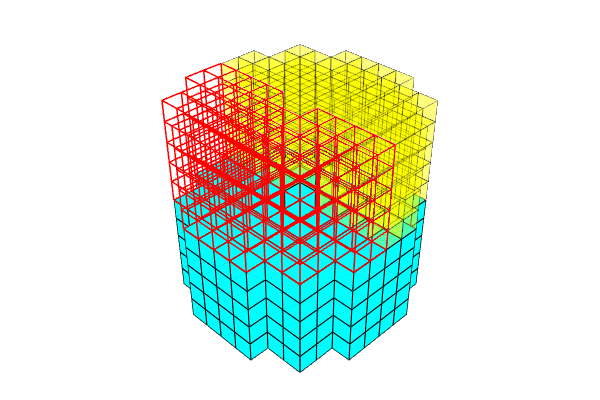

In [30]:
mesh.pvplot(notebook=True, jupyter_backend='static', cmap='plasma',
            window_size=(600, 400), config_key=('pyvista', 'plot'))


In [31]:
from k3d import matplotlib_color_maps

mesh['lines', 'L2'].config['k3d', 'plot', 'color'] = 'red'
mesh['lines', 'L2'].config['k3d', 'plot', 'width'] = 0.2

mesh['surfaces', 'Q4'].config['k3d', 'plot', 'color'] = 'yellow'
mesh['surfaces', 'Q4'].config['k3d', 'plot', 'opacity'] = 0.3

mesh['bodies', 'H8'].config['k3d', 'plot', 'color'] = 'cyan'
mesh['bodies', 'H8'].config['k3d', 'plot', 'opacity'] = 1.0


In [34]:
plot = mesh['lines', 'L2'].k3dplot(config_key=('k3d', 'plot'))
plot.display()


Output()

In [35]:
plot = mesh.k3dplot(config_key=('k3d', 'plot'))
plot.display()


Output()

The K3D library is simply amazing, and it lets you save the content directly into html with or without the necessary javascript included:

In [36]:
with open('fig-01.html', 'w') as f:
    plot.snapshot_include_js = True
    f.write(plot.get_snapshot())

We can assign colors by setting numerical data on points or cells. All we have to do
is to provide the keyword argument ``scalars`` to `PyVista`. One way to do that is to
add these walues to the configuration of your block of choice. For example, to set random data on H8 hexagonals, do this:

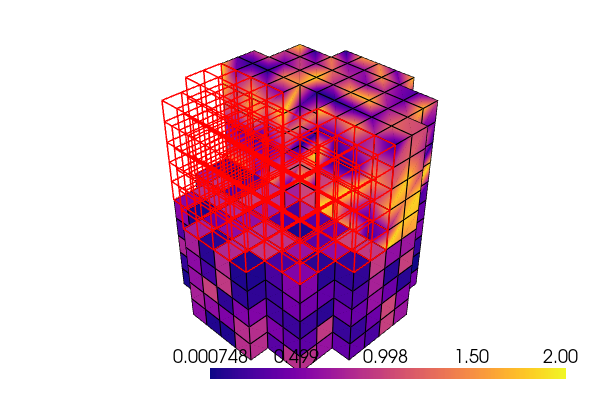

In [9]:
mesh['bodies', 'H8'].config['pyvista', 'plot',
                            'scalars'] = np.random.rand(tH8.shape[0])
ncTET4 = mesh['surfaces', 'Q4'].coords(from_cells=True).shape[0]
mesh['surfaces', 'Q4'].config['pyvista', 'plot',
                              'scalars'] = 2*np.random.rand(ncTET4)
mesh['surfaces', 'Q4'].config['pyvista', 'plot', 'opacity'] = 1.0
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma')


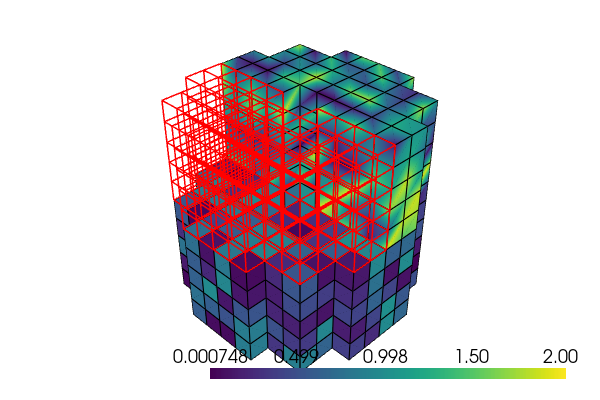

In [10]:
import pyvista as pv
plotter = pv.Plotter()
mesh.pvplot(plotter=plotter, config_key=('pyvista', 'plot'))
plotter.show(jupyter_backend='static', window_size=(600, 400))


### Background Plotting

This requires you to have `PyQt` and `pyvistaqt` installed, but it possible to plot
using a widget:

In [11]:
from pyvistaqt import BackgroundPlotter
plotter = BackgroundPlotter()
mesh.pvplot(plotter=plotter, config_key=('pyvista', 'plot'))
plotter.show()


In [12]:
mesh.lock(create_mappers=True)


PolyData({'lines': PolyData({'L2': PolyData({})}), 'surfaces': PolyData({'Q4': PolyData({})}), 'bodies': PolyData({'H8': PolyData({})})})

In [25]:
block = mesh.blocks_of_cells(2345)[2345]
block.pvplot(notebook=True, jupyter_backend='pythreejs',
             window_size=(600, 400), config_key=('pyvista', 'plot'), 
             cmap='jet')


Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…